<a href="https://colab.research.google.com/github/scottspurlock/csc4466-s2024/blob/main/projects/project01_image_alignment_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 4466 Computer Vision
## Project 1 - Russian Images
### *** Zhuohao Tan ***
The goal of this assignment is to take the digitized Prokudin-Gorskii glass plate images and, using image processing techniques, automatically produce a color image with as few visual artifacts as possible. In order to do this, you will need to extract the three color channel images, place them on top of each other, and align them so that they form a single RGB color image. We will assume that a simple x,y translation model is sufficient for proper alignment and will ignore other potential changes such as rotation.

## Discussion
Fill in this part last. Include a couple paragraphs discussing
- your results
- how well things worked. Make sure to mention test2.jpg and the big tiff images.
- how you selected any parameters to make things work better
- run time and what factors affect it
- how you can judge success of your results
- limitations and what you would do next with more time
- evaluation with respect to the assignment requirements. Does your work
  - completely meet the requirements
  - nearly meet the requirements
  - somewhat meet the requirements


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [ ]:
def translate(img, x, y):
    ''' Translate the given image (or color channel) by the given offset in the
        given x and y directions.

        Returns the translated image (or color channel).
    '''
    # TODO
    rows, cols = img.shape[:2]

    M = np.array([[1,0,x],
                  [0,1,y]], float)

    img_translated = cv2.warpAffine(img, M, (cols, rows))

    return img_translated


In [ ]:
# Test translate function
# ------------------------

# Make a 3x3 array of ones
# 1 1 1
# 1 1 1
# 1 1 1
A = np.ones((3, 3), np.uint8)

# This should print
# 0 0 0
# 0 1 1
# 0 1 1
print()
print('Testing translate down and right...')
print(translate(A, 1, 1))

# This should print
# 1 1 0
# 1 1 0
# 0 0 0
print()
print('Testing translate up and left...')
print(translate(A, -1, -1))


Testing translate down and right...
[[0 0 0]
 [0 1 1]
 [0 1 1]]

Testing translate up and left...
[[1 1 0]
 [1 1 0]
 [0 0 0]]


In [ ]:
def compute_ssd(I1, I2):
    ''' Compute the sum-of-squared differences between two color channels.

    Find the difference between the channels (subtract), square the difference,
    and then sum up the squared differences over all the pixels. This should
    require no explicit loops. Potentially helpful method: np.sum().

    Think carefully about math and data types to avoid overflow (wrapping
    around). Since this method is returning a single number (not an image), it's
    ok that the result be a float rather than an unsigned 8-bit integer.
    '''
    ssd = 0
    # TODO: return the sum-of-squared-differences (one number)
    I1 = I1.astype(float)
    I2 = I2.astype(float)

    difference = I1 - I2
    difference *= difference
    ssd = difference.sum()

    return ssd


In [ ]:
# Test compute_ssd function
# ------------------------

# Make a 3x3 array of zeros
# 0 0 0
# 0 0 0
# 0 0 0
A = np.zeros((3, 3), np.uint8)

# Make a 3x3 array of 255's
# 255 255 255
# 255 255 255
# 255 255 255
B = 255 + np.zeros((3, 3), np.uint8)

# This should print 585225.0
print()
print('Testing ssd ...')
print(compute_ssd(A, B))

# This should also print 585225.0
print()
print('Testing ssd ...')
print(compute_ssd(B, A))



Testing ssd ...
585225.0

Testing ssd ...
585225.0


In [ ]:
def align_channels(I1, I2):
    ''' Compute the best offset to align the second channel with the first.

     I1 and I2 should be 2D numpy arrays with the same number of rows and cols.

     Loop over a range of offset values in the x and y directions. (Use nested
     for loops.) For each possible (x, y) offset, translate the second channel
     and then check to see how well it lines up with the first channel by
     calling the compute_ssd function. (Lower SSD is better.)

     Return the x,y translation that best aligns second channel.
    '''
    bestX = 0
    bestY = 0

    # TODO
    rows, cols = I2.shape[:2]
    min_ssd = np.inf

    for row in range(rows-rows//2, -rows+rows//2, -1):
      for col in range(cols-cols//2, -cols+cols//2,-1):
        translated_I2 = translate(I2, col, row)
        ssd = compute_ssd(translated_I2, I1)
        if ssd < min_ssd:
          min_ssd = ssd
          bestX = col
          bestY = row

    return bestX, bestY

In [ ]:
# Test align_channels function
# ------------------------

# Make a 3x3 array of zeros with a 1 in the middle
# 0 0 0
# 0 1 0
# 0 0 0
A = np.zeros((3, 3), np.uint8)
A[1, 1] = 1

# Make a 3x3 array of zeros with a 1 at the top left
# 0 0 1
# 0 0 0
# 0 0 0
B = np.zeros((3, 3), np.uint8)
B[0, 2] = 1

# This should print (-1, 1)
print()
print('Testing aligning B with A...')
print(align_channels(A, B))

# This should print (1, -1)
print()
print('Testing aligning A with B...')
print(align_channels(B, A))


Testing aligning B with A...
(-1, 1)

Testing aligning A with B...
(1, -1)


In [ ]:
def process_image(img):
    '''
    Process a "Russian Image" to separate out the color channels and align them.

    The input image should be 2D. Assume that the top third
    of the input can be used as the blue channel of a color image, the middle
    third as the green channel, and the bottom third as the red channel.

    For example, if the input is:
    0   0   0
    0   255 0
    255 0   0
    0   0   0
    0   0   0
    0   0   255

    Then the blue channel is the top third:
    0   0   0
    0   255 0

    and the green channel is the middle third:
    255 0   0
    0   0   0

    and the red channel is the bottom third:
    0   0   0
    0   0   255

    The function should call the align_channels function to determine the best
    alignment of the green channel with the blue channel, then the red channel
    with the blue channel.

    Then the green and red channels can each be translated based on the best
    alignments, and finally the 3 channels can be merged into a color photo.

    Returns the aligned color image.
    '''

    # TODO
    numPerRows = img.shape[0] // 3

    b = img[:numPerRows, :]
    g = img[numPerRows:numPerRows*2, :]
    r = img[numPerRows*2:numPerRows*3, :]

    x, y = align_channels(b, g)
    new_g = translate(g, x, y)

    x, y = align_channels(b, r)
    new_r = translate(r, x, y)

    return cv2.merge((b,new_g,new_r))



Testing processing image...


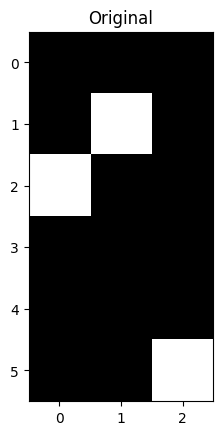

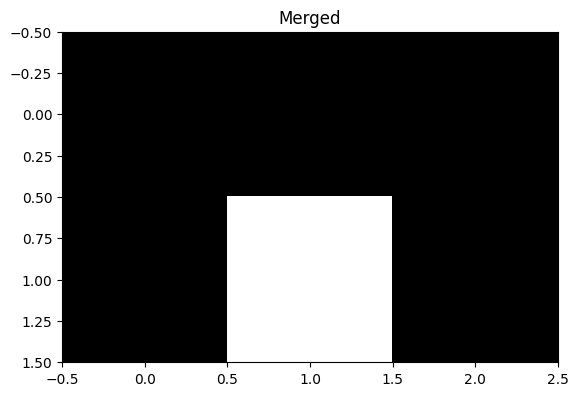

In [ ]:
# Test process_image function
# ------------------------

# Make a 6x3 array of zeros with 255's
# 0   0   0
# 0   255 0
# 255 0   0
# 0   0   0
# 0   0   0
# 0   0   255
A = np.zeros((6, 3), np.uint8)
A[1, 1] = 255
A[2, 0] = 255
A[5, 2] = 255

# This should display a 2 x 3 image with one white pixel at (1, 1)
print('Testing processing image...')

plt.imshow(A, cmap='gray', vmin=0, vmax=255)
plt.title('Original')
plt.show()
print()

merged = process_image(A)
rgb = cv2.cvtColor(merged, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.title('Merged')
plt.show()

In [ ]:
from skimage import metrics

def nonlinear_RC(img):
  img = img.astype(float)
  return ((img / 255) ** 2) * 255

def compute_ssim(I1, I2):
  ssim_score = metrics.structural_similarity(I1[25:I1.shape[0]-25, 25:I1.shape[1]-25], I2[25:I2.shape[0]-25, 25:I2.shape[1]-25], full=True)
  return ssim_score[0]

def compute_ssd(I1, I2):
    ssd = 0

    I1 = I1.astype(float)
    I2 = I2.astype(float)

    I1 = I1[50:I1.shape[0]-50, 100:I1.shape[1]-100]
    I2 = I2[50:I2.shape[0]-50, 100:I2.shape[1]-100]

    I1 = nonlinear_RC(I1)
    I2 = nonlinear_RC(I2)

    difference = I1 - I2
    difference *= difference
    difference /= (255**2)
    ssd = difference.sum()

    return ssd

def align_channels(I1, I2):

    bestX = 0
    bestY = 0

    rows, cols = I2.shape[:2]
    min_ssd = -1

    for row in range(50, -50, -2):
      for col in range(50, -50,-2):
        translated_I2 = translate(I2, col, row)
        ssd = compute_ssim(I1, translated_I2)
        if ssd > min_ssd:
          min_ssd = ssd
          bestX = col
          bestY = row

    return bestX, bestY

def process_image(img):

    numPerRows = img.shape[0] // 3

    b = img[:numPerRows, :]
    g = img[numPerRows:numPerRows*2, :]
    r = img[numPerRows*2:numPerRows*3, :]

    x, y = align_channels(b, g)
    new_g = translate(g, x, y)

    x, y = align_channels(b, r)
    new_r = translate(r, x, y)

    return cv2.merge((new_r, new_g, b))


def read_and_align(filename):
    '''
    Given a filename as a string, e.g., 'test.jpg', this function will
    - read in the image
    - convert it to grayscale (make it 2D)
    - display the grayscale image
    - call process_image to split and merge the channels
    - display the aligned final image
    '''

    # TODO
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img = process_image(img)
    fig = plt.figure(figsize=(18, 10))
    plt.imshow(final_img)


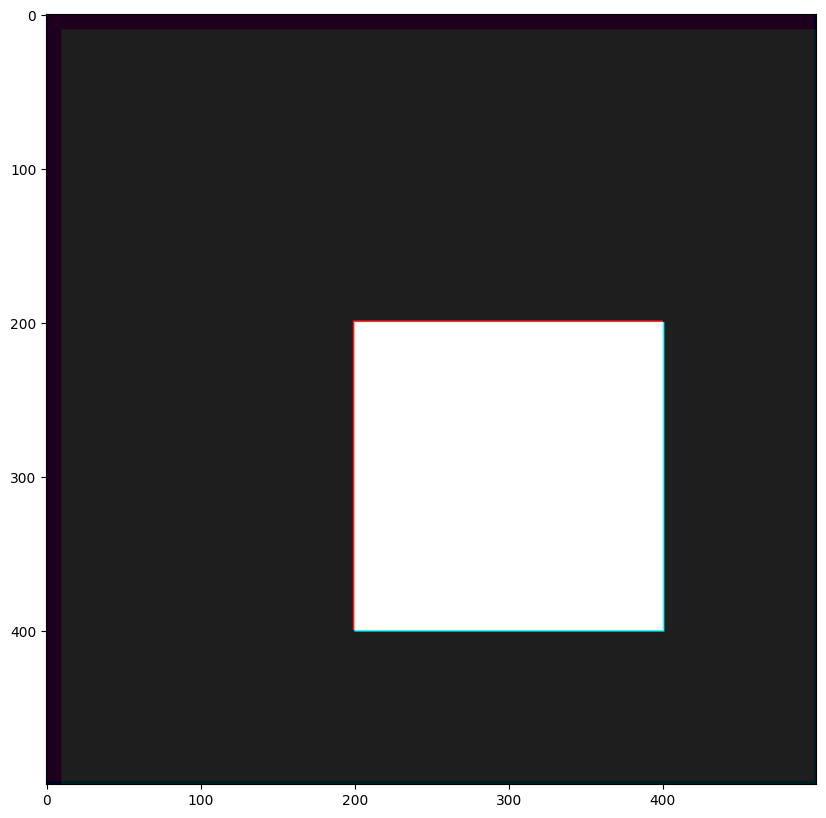

In [ ]:
# Test read_and_align function with test.jpg
# --------------------------------------------
# Should display a single white square on a black background.
image_name = 'test.jpg'
read_and_align(image_name)


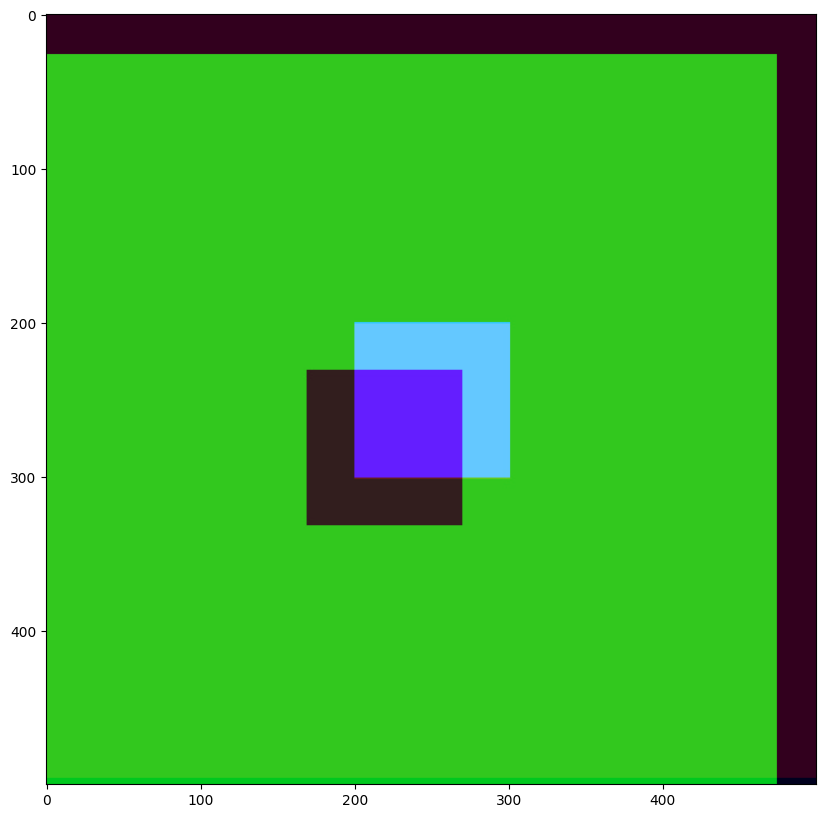

In [ ]:
# Test read_and_align function with test2.jpg
# --------------------------------------------
# Ideally would display a single blue box on a green background,
# but probably won't work quite right.
image_name = 'test2.jpg'
read_and_align(image_name)


In [ ]:
# Test code with various input images
# --------------------------------------------
#image_filenames = ['tobolsk.jpg',
#                   'settlers.jpg',
#                   'cathedral.jpg',
#                   'monastery.jpg']
#
#for image_name in image_filenames:
#    print(f'Testing {image_name}...')
#    read_and_align(image_name)
#    print()


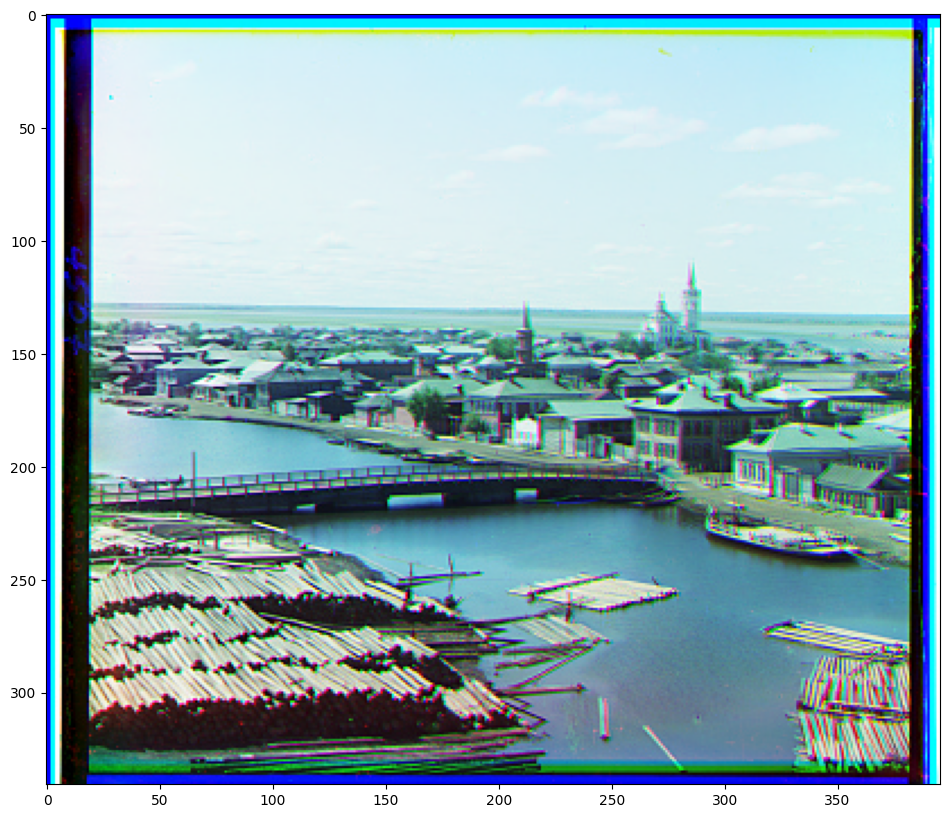

In [ ]:
image_name = 'tobolsk.jpg'
read_and_align(image_name)

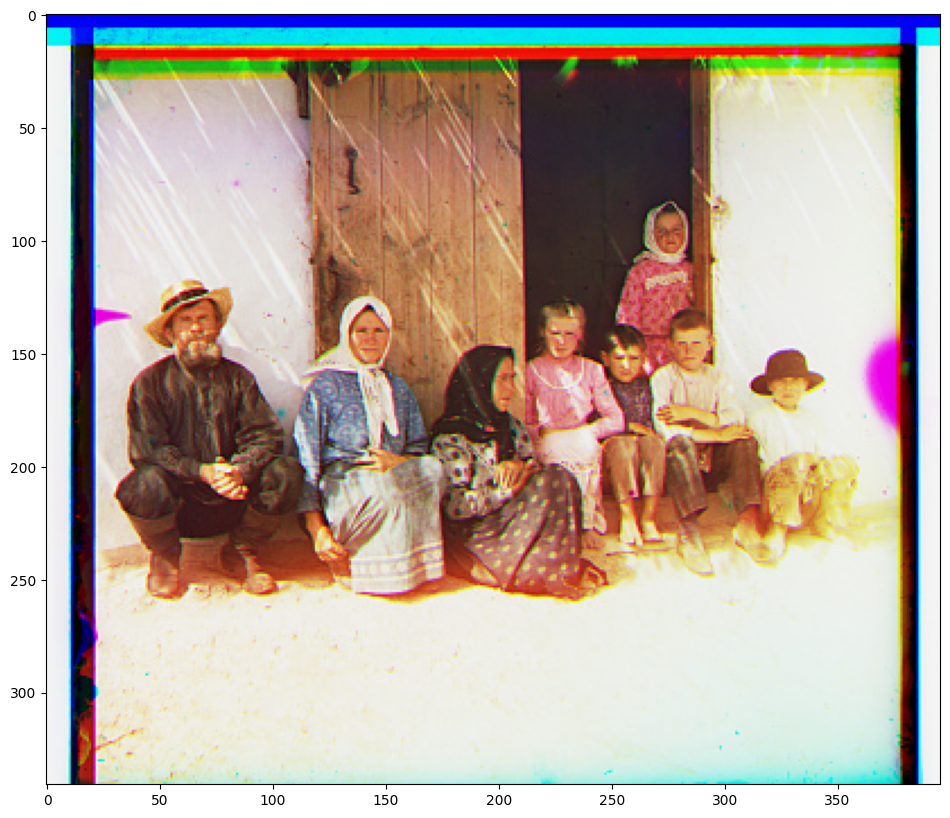

In [ ]:
image_name = 'settlers.jpg'
read_and_align(image_name)

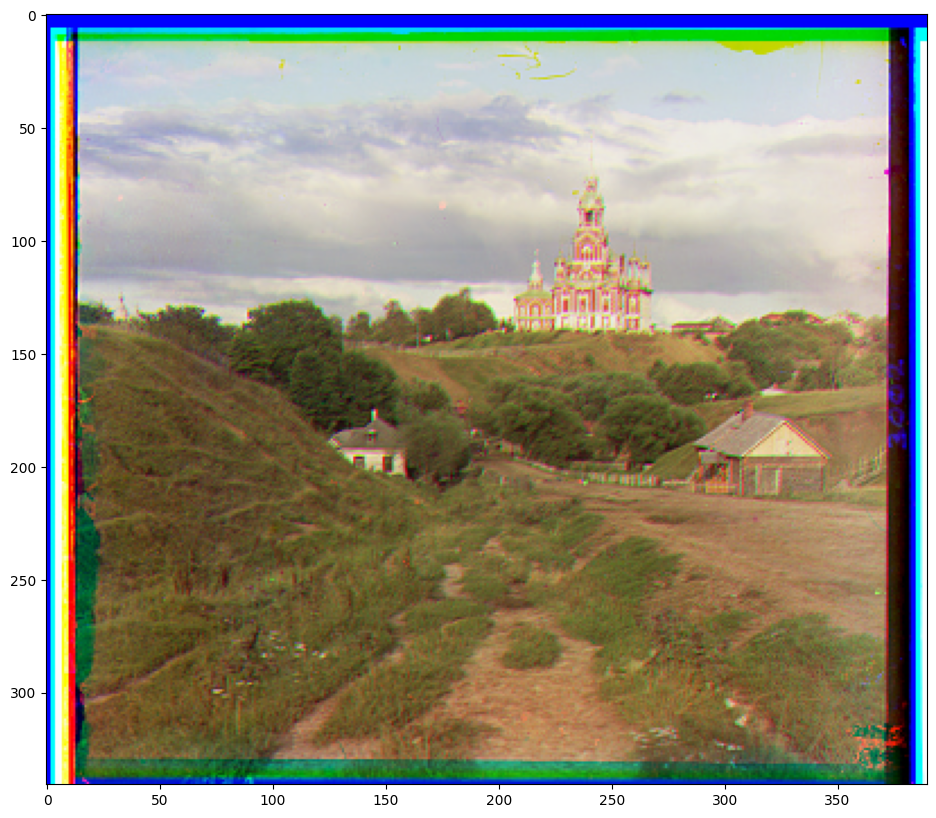

In [ ]:
image_name = 'cathedral.jpg'
read_and_align(image_name)

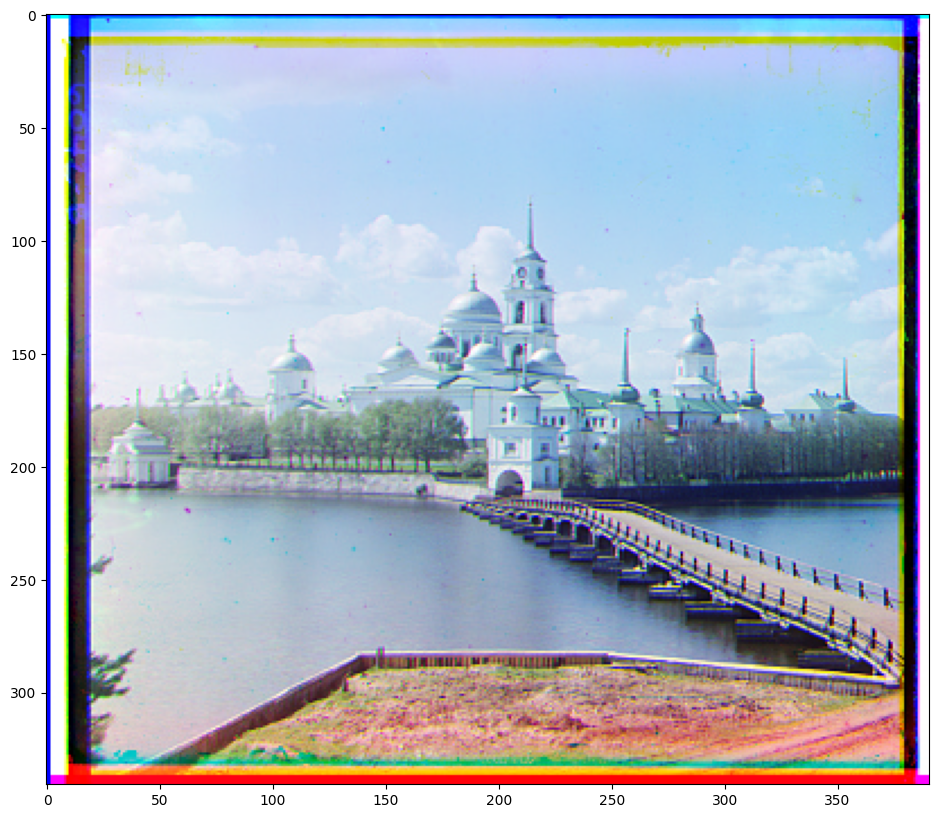

In [ ]:
image_name = 'monastery.jpg'
read_and_align(image_name)

In [ ]:
from skimage import metrics

def nonlinear_RC(img):
  img = img.astype(float)
  return ((img / 255) ** 2) * 255

def compute_ssim(I1, I2):
  ssim_score = metrics.structural_similarity(I1[500:I1.shape[0]-500, 500:I1.shape[1]-500], I2[500:I2.shape[0]-500, 500:I2.shape[1]-500], full=True)
  return ssim_score[0]

def compute_ssd(I1, I2):
    ssd = 0

    I1 = I1.astype(float)
    I2 = I2.astype(float)

    I1 = I1[50:I1.shape[0]-50, 100:I1.shape[1]-100]
    I2 = I2[50:I2.shape[0]-50, 100:I2.shape[1]-100]

    I1 = nonlinear_RC(I1)
    I2 = nonlinear_RC(I2)

    difference = I1 - I2
    difference *= difference
    difference /= (255**2)
    ssd = difference.sum()

    return ssd

def align_channels(I1, I2):

    bestX = 0
    bestY = 0

    rows, cols = I2.shape[:2]
    min_ssd = -1

    for row in range(25, -25, -5):
      for col in range(25, -25,-5):
        translated_I2 = translate(I2, col, row)
        ssd = compute_ssim(I1, translated_I2)
        if ssd > min_ssd:
          min_ssd = ssd
          bestX = col
          bestY = row

    return bestX, bestY

def process_image(img):

    numPerRows = img.shape[0] // 3

    b = img[:numPerRows, :]
    g = img[numPerRows:numPerRows*2, :]
    r = img[numPerRows*2:numPerRows*3, :]

    x, y = align_channels(b, g)
    new_g = translate(g, x, y)

    x, y = align_channels(b, r)
    new_r = translate(r, x, y)

    return cv2.merge((new_r, new_g, b))


def read_and_align(filename):
    '''
    Given a filename as a string, e.g., 'test.jpg', this function will
    - read in the image
    - convert it to grayscale (make it 2D)
    - display the grayscale image
    - call process_image to split and merge the channels
    - display the aligned final image
    '''

    # TODO
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img = process_image(img)
    fig = plt.figure(figsize=(18, 10))
    plt.imshow(final_img)


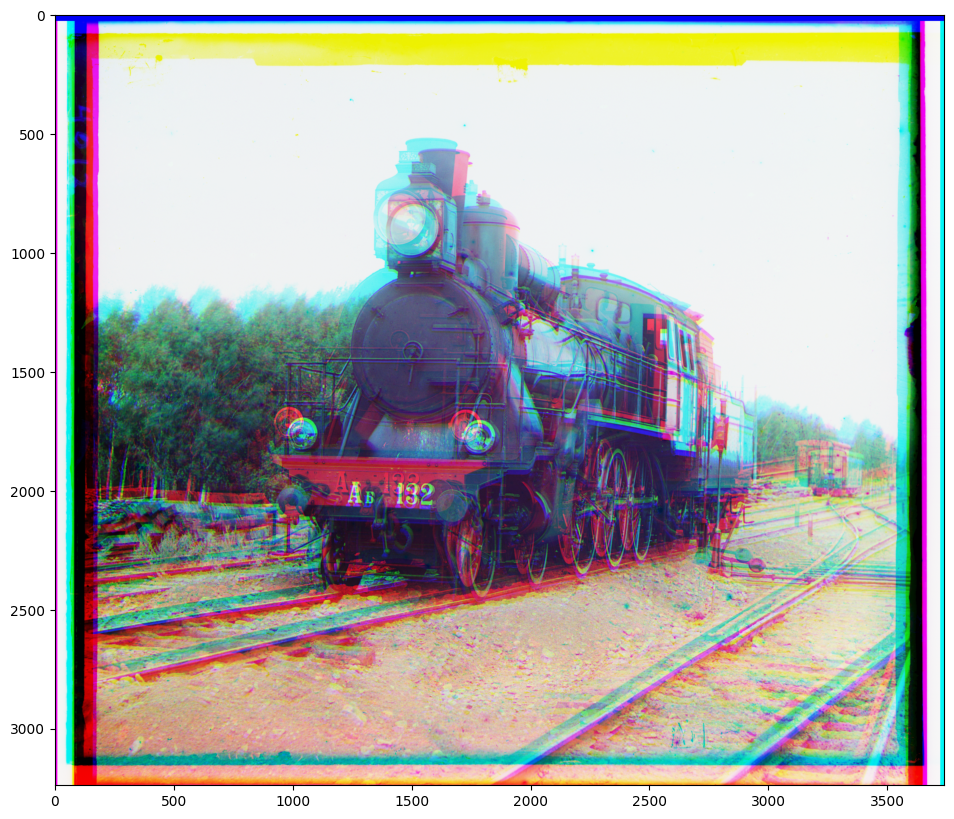

In [ ]:
image_name = 'train.tif'
read_and_align(image_name)

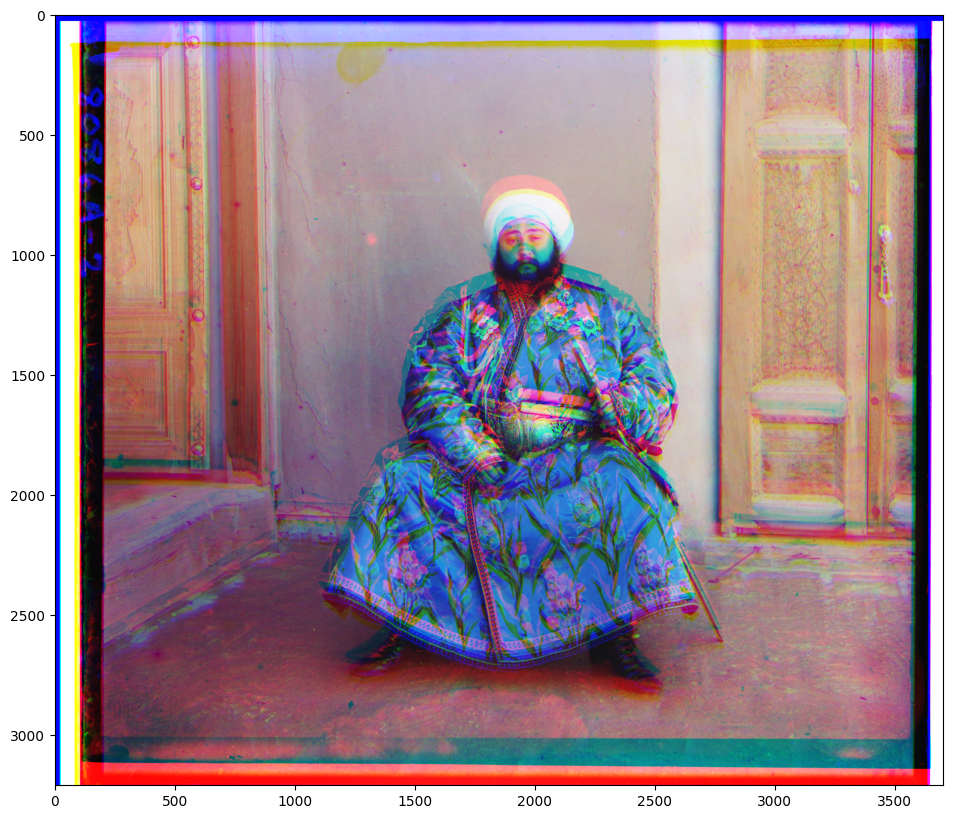

In [ ]:
image_name = 'emir.tif'
read_and_align(image_name)

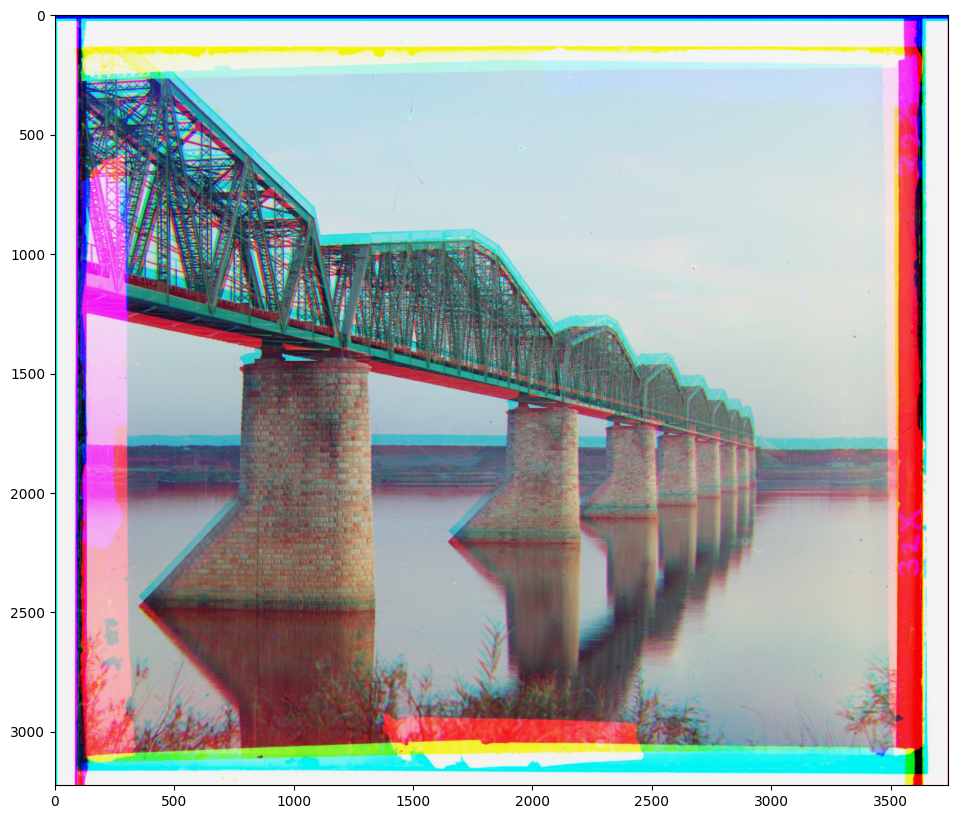

In [ ]:
image_name = 'bridge.tif'
read_and_align(image_name)

# Write Up

1. your results and how well things worked. Make sure to mention test2.jpg and the big tiff images.
    The result go okay with the other images excpet test2.jpg and the big tiff images. The test2.jpg is kinda working a little since the green background. But I also tested with SSIM, which compare the image based on their structures. So I think they have similar structures and there should not be much translation of the images. However, I'm not able to get the correct result based on SSIM. but I think it is also hard to use SSD to get a right result since the images are in an very interesting colors. The results for the big tiff images are not that good tho. However I think their result will be better if i'm using the SSD instead of SSIM.

2. how you can judge the success of your results (qualitative and quantitative).
    I think the success of my results is more on quantitative

3. how you selected any parameters to make things work better.
    It depend on the image, and also the input image, how different they are in terms of the location the strucutures. If the images are kinda close to each other in the sturcutures wise. I give a small offsets range for translation. That will improve the speed. Also, depend on how big the image is I will change the number of the pixels to consider. If the image is big. I will try to ignore more pixels at the edges.

4. which challenge(s) you implemented.
    Modify your SSD method to only consider pixels in the center of the images. We might expect that pixels near the edges would be “noisier” and likely to adversely affect our alignment, so by using a mask or array slicing to ignore some pixels, we might get better results. Note that applying a mask to an image will likely not work as well as applying a mask to the differences between images.

    Modify your SSD method in some other way to improve results (e.g., to get test2.jpg to work). This could involve a different metric for computing how different two images are, or modifying the images in some way before computing the differences. (I tried to use SSIM)

5. run time and what factors affect it.
    The rum time is constant. Since I didnt loop through the image based on how large it is. since more of the image is very simliar in terms of their sturcture. Like the locations of each stuffs in the image is not too far away. So I put a constant number for 2 of the for loop. However, there might be more becuase of the calculations I preformed (SSIM).

6. limitations and what you would do next with more time.
    I think the limitation is run time is too long, If I would do next with more time, I think I might try to minimize/ignmore the number of pixels and use SSIM. Since it will comparing the different in terms of the structures of the images

7. evaluation with respect to the assignment rubric (below). Does your work
    
    my work completely meet the requirements:
    All functions are successfully completed
    * At least one challenge item is successfully completed
    * Results for all tests are shown in the notebook
    * Aligned image results are shown in the notebook for test.jpg, test2.jpg, tobolsk.jpg, settlers.jpg, cathedral.jpg, and monastery.jpg
    * Code does a good job aligning test.jpg, tobolsk.jpg, and settlers.jpg
    * Code may have some issues with some of the other images
    * Discussion at top of notebook completely addresses all 7 points mentioned in “Write-up” above


